# Model SIRQ: Susceptible, Infected, Recovered, and Quarantine

In [2]:
from tqdm import tqdm

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

In [3]:
# pip install casadi --break-system-packages
from casadi import MX, Function, vertcat, vertsplit, hcat, nlpsol, sum1, inf

from scipy.optimize import root
from gekko import GEKKO

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Simulator

### Simulator Class

In [5]:
# SIRQ class

class SIRQ:
    def __init__(self, theta, epsilon=1e-5):
        """
        initializes parameters and states as following:
         * state: [S, I, R, Q, D]
         * theta: [beta, gamma_I, gamma_Q, mu_I, mu_Q, delta]
        """
        
        self.theta = theta
        self.start(epsilon)

    def start(self, epsilon=1e-5):
        """starts model and defines initial infected population"""
        self.state = np.array([1.0,0.0,0.0,0.0,0.0])

        # inits with epsilon infected
        self.state[0] = self.state[0] - epsilon # S
        self.state[1] = self.state[1] + epsilon # I

        return self.state

    def update(self, u=0, h=1):
        """updates the state given a dinamics, control and stepsize"""

        dx= np.zeros(self.state.shape)

        # system dynamics
        dx[0] = self.theta[5]*self.state[2] - self.theta[0]*self.state[0]*self.state[1]
        dx[1] = self.theta[0]*self.state[0]*self.state[1] - self.theta[1]*self.state[1] - u*self.state[1] - self.theta[3]*self.state[1]
        dx[2] = self.theta[1]*self.state[1] + self.theta[2]*self.state[3] - self.theta[5]*self.state[2]
        dx[3] = u*self.state[1] - self.theta[2]*self.state[3] - self.theta[4]*self.state[3]
        dx[4] = self.theta[3]*self.state[1] + self.theta[4]*self.state[3]

        # udpdates state
        self.state = self.state + h*dx

        return self.state

### Generate Simulated Artificial Data

Here, we also include some random control decisions, as to get a sequence of usefull (Q,u) data sequences

In [6]:
# sets dynamics with random control
def simulate(sample_lenght, theta, u_max, u_min, epsilon=1e-5, model=None):
  if model is None:
    model = SIRQ(theta, epsilon)

  states = np.zeros((sample_lenght, model.state.shape[0] + 1))
  for i in range(sample_lenght):
      u = np.random.uniform(u_min, u_max)
      states[i,-1] = u
      states[i,:-1] = model.state
      model.update(u)

  return states

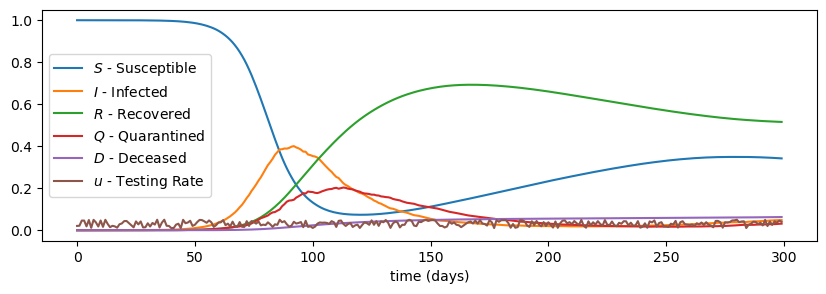

In [119]:
theta = np.array([0.2, 0.02, 0.04, 0.002, 0.001, 0.005])
sample = simulate(sample_lenght=300, theta=theta, u_min=0.01, u_max=0.05, epsilon=1e-5)

plt.figure(figsize=(10,3))
plt.plot(sample[:,0], label = "$S$ - Susceptible")
plt.plot(sample[:,1], label = "$I$ - Infected")
plt.plot(sample[:,2], label = "$R$ - Recovered")
plt.plot(sample[:,3], label = "$Q$ - Quarantined")
plt.plot(sample[:,4], label = "$D$ - Deceased")
plt.plot(sample[:,5], label = "$u$ - Testing Rate")

# plt.ylabel("Population")
plt.xlabel("time (days)")

plt.legend()
plt.savefig("sirq_figures/sirq_model_sample.svg", bbox_inches='tight', format="svg")
plt.show()

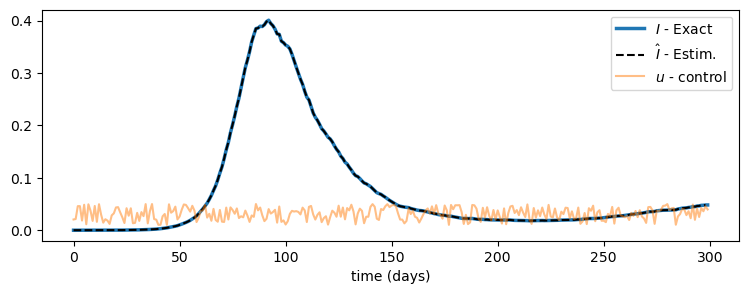

In [128]:
# expression to recover infected states
i_hat = (sample[1:,3] - sample[:-1,3]*(1-theta[2]-theta[4]))/sample[:-1,-1]

plt.figure(figsize=(9,3))

plt.plot(sample[:,1], label = "$I$ - Exact", linewidth=2.5)
plt.plot(i_hat, '--', label = "$\\hat{I}$ - Estim.", color="k")
plt.plot(sample[:,-1], label = "$u$ - control", alpha=0.5)

# plt.ylabel("Infected Population")
plt.xlabel("time (days)")

plt.legend()
plt.savefig("sirq_figures/infected_observation.svg", bbox_inches='tight', format="svg")
plt.show()

### Parameters, Weights and Restrictions

In [9]:
# define new parameters
beta = 0.04     # infection rate
gamma_i = 0.01  # recovery rate infected
gamma_q = 0.025 # recovery rate quarantine
mu_i = 0.002    # mortality rate infected
mu_q = 0.001    # mortality rate quarantine
delta = 0.001   # reinfection rate

theta = np.array([beta, gamma_i, gamma_q, mu_i, mu_q, delta])

# maximun theta range (relavant for training)
theta_max = np.array([1,0.1,0.1,0.01,0.01,0.01])

In [10]:
# initial infection level
epsilon = 1e-5

In [11]:
mpc_lenght = 10     # mpc horison steps
input_lenght = 30   # observation steps

sample_lenght = 1000

In [12]:
# cost weights
c_Q = 10
c_I = 10

# control limits
u_max = 0.04
u_min = 0.001

# state restrictions
i_max = 0.02

## MPC from State Observer and Parameter Estimation

### LSTM-Based State Observer

In [13]:
def train_generator_observer(n_samples, input_lenght, u_max, u_min, theta_max, scaler=None):
  while True:
    # formats data
    x_train = np.zeros((n_samples, input_lenght, 3))
    y_train = np.zeros((n_samples, input_lenght, 2))

    for i in range(n_samples):
      # samples random parameters
      theta = np.random.uniform(high=theta_max)

      # random initial state
      model = SIRQ(theta)
      
      # evolves inputs and outputs
      sample = simulate(input_lenght, theta, u_max, u_min, model=model)
      
      # updates train data
      x_train[i, :, :] = sample[:, [1,3,5]] # gets: I, Q, u
      y_train[i, :, :] = sample[:, [0,2]] # gets: S, R

      # checks for scaling
      if scaler is not None:
         x_train[i,:,:] = scaler.transform(x_train[i,:,:])

      # adjusts scale
      x_train[i,:,:] = x_train[i, :, :]

    yield x_train, y_train


def get_scaler_observer(n_samples, input_lenght, u_max, u_min, theta_max):
    # gets a sample generator
    generator = train_generator_observer(n_samples, input_lenght, u_max, u_min, theta_max)
    # samples then fit scaler
    x_train, _ = next(generator)
    x_train = np.vstack(x_train)
    scaler = MinMaxScaler().fit(x_train)
    
    return scaler

In [14]:
input_size = 3
output_size = 2

lstm_state_observer = tf.keras.models.Sequential()

#Adding LSTM layers
lstm_state_observer.add(tf.keras.layers.LSTM(10, return_sequences = True, input_shape = (None, input_size)))
lstm_state_observer.add(tf.keras.layers.LSTM(10, return_sequences = True))

#Adding the output layer
lstm_state_observer.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_size)))

# compiling
lstm_state_observer.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

# # summary
# print(regressorLSTM.summary())

In [ ]:
# scaler = get_scaler_observer(1000, 300, u_max=u_max, u_min=u_min)
# generator = train_generator_observer(100, 300, u_max=u_max, u_min=u_min, scaler=scaler)
generator = train_generator_observer(100, 300, u_max=u_max, u_min=u_min, theta_max=theta_max)

lstm_state_observer.fit(generator, steps_per_epoch=10000, epochs=20, verbose=1)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2046s 204ms/step - loss: 0.0174 - mean_absolute_error: 0.0799
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2082s 208ms/step - loss: 0.0034 - mean_absolute_error: 0.0385
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2260s 226ms/step - loss: 0.0025 - mean_absolute_error: 0.0319
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2013s 201ms/step - loss: 0.0023 - mean_absolute_error: 0.0298
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2012s 201ms/step - loss: 0.0022 - mean_absolute_error: 0.0288
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2012s 201ms/step - loss: 0.0021 - mean_absolute_error: 0.0279
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2010s 201ms/step - loss: 0.0020 - mean_absolute_error: 0.0273
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2008s 201ms/step - loss: 0.0019 - mean_absolute_error: 0.0266
Epoch 9/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2010s 201ms/step - loss: 0.0019 - mean_absolute_error: 0.0264
Epoch 10/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2

In [15]:
filename = 'observer_files/lstm_state_observer.keras'

# save/load the model
# lstm_state_observer.save(filename)
lstm_state_observer = keras.models.load_model(filename)

#### Check Adjustment Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


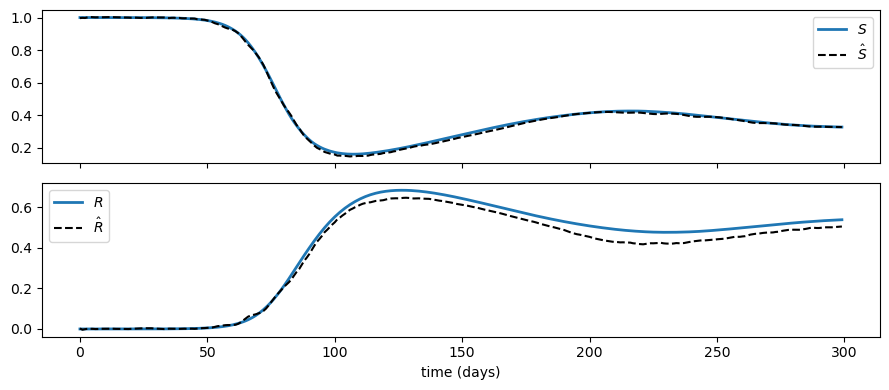

In [16]:
# gets a random sample
generator = train_generator_observer(1, 300, u_max=u_max, u_min=u_min, theta_max=theta_max)
sample_x, sample_y = next(generator)
observed_y = lstm_state_observer.predict(sample_x)

# plot afjustments
fig, ax = plt.subplots(output_size, figsize=(9,4), sharex=True)

c = 0
for i, state in enumerate("SIRQD"):
    if state in "IQD":
        continue
    ax[c].plot(sample_y[0,:,c], label="${}$".format(state), linewidth=2)
    ax[c].plot(observed_y[0,:,c], "--", color="k", label="$\hat {}$".format(state))
    ax[c].legend()
    c += 1

plt.xlabel("time (days)")
fig.tight_layout()
plt.legend()
plt.savefig("observer_figures/lstm_observation.svg", bbox_inches='tight', format="svg")
plt.show()

### Model Dynamics and Integrators

In [17]:
# defines the dynamics under SIRQ model
def sirq_dynamics(x, u, theta):
    # states
    s, i, r, q, d = vertsplit(x)
    # params
    beta, gamma_i, gamma_q, mu_i, mu_q, delta = vertsplit(theta)

    # model
    sdot = delta*r - beta*s*i
    idot = beta*s*i - gamma_i*i - mu_i*i - u*i
    rdot = gamma_i*i + gamma_q*q - delta*r
    qdot = u*i - gamma_q*q - mu_q*q
    ddot = mu_i*i + mu_q

    return vertcat(sdot, idot, rdot, qdot, ddot)

In [18]:
# integrate with Explicit Euler
def integrate_euler(f, x0, u, theta, dt = 0.01, steps = 100):
    xj = x0
    for _ in range(steps):
        fj = f(xj,u,theta)
        xj += dt*fj
    return xj

In [19]:
# State and Control (symbolics)
u_ = MX.sym("u", 1)
x_ = MX.sym("x", 5)

# System parameters (symbolics)
theta_ = MX.sym("theta", 6)

# System dynamics (symbolics)
xdot_ = sirq_dynamics(x_,u_,theta_)
f_ = Function('f', [x_,u_,theta_],[xdot_])

# Discrete approximator function
xf_ = integrate_euler(f_, x_, u_, theta_)
F = Function('F', [x_,u_,theta_],[xf_])

### MSE Parameter Estimation


In [20]:
def estimate_theta(U, X_obs):
    n = len(X_obs)-1
    m = len(X_obs[0])

    phi = np.zeros((m*n, 4))
    con = np.zeros((m*n, ))
    omh = np.zeros((m*n, ))
    aux1 = np.zeros((m*n, ))
    aux2 = np.zeros((m*n, ))
    
    for k in range(n):
        # extracts states
        S,I,R,Q,D = X_obs[k]
       
        # mount A(X_k) matrixes only for unknown parameters
        phi[5*k:5*(k+1),:]= np.array([
            [-S*I, 0, 0, R],
            [S*I, -I, -I, 0],
            [0, I, 0, -R],
            [0, 0, 0, 0],
            [0, 0, I, 0],
        ])

        # mounts dX matrix
        omh[5*k:5*(k+1)] = X_obs[k+1] - X_obs[k]
        
        # mounts u matrixes
        con[5*k:5*(k+1)] = U[k]*np.array([0,-I,0,I,0]).ravel()

        # mounts auxiliary matrix
        aux1[5*k:5*(k+1)] = gamma_q*np.array([0,0,Q,-Q,0]).ravel()
        aux2[5*k:5*(k+1)] = mu_q*np.array([0,0,0,-Q,Q]).ravel()

    # solves system
    theta = np.linalg.lstsq(phi, omh-con-aux1-aux2, rcond=None)[0]
    return theta


### MPC Step - Optimal Control Computation 

In [21]:
def mpc_step_observer(F, theta, X0, mpc_lenght, i_max, c_Q=10, c_I=100):
    # Control for all segments
    U = MX.sym("U", mpc_lenght)

    # Integrate over all intervals
    X=[X0]
    for i in range(mpc_lenght-1):
        X.append(F(X[-1],U[i],theta))
    X = hcat(X)

    # gets only relevant states
    I = X[1,:].T
    Q = X[3,:].T

    # Objective function and constraints
    J = sum1(U**2*(1-Q)**2 + c_Q*Q**2 + c_I*I**2)
    G = vertcat(I, U*(1-Q))

    # Allocate an NLP solver
    nlp = {'f':J, 'x':U, 'g':G}
    opts = {"ipopt.print_level":0, "print_time":0}
    solver = nlpsol("solver", "ipopt", nlp, opts)

    # Bounds on u and initial condition
    arg = dict()
    arg["lbg"] = [-inf]*mpc_lenght + [u_min]*mpc_lenght
    arg["ubg"] = [i_max]*mpc_lenght + [u_max]*mpc_lenght

    # Solve the problem
    res = solver(**arg)

    # gets first step solution
    return res["x"][0]


### Experiments and Results

In [106]:
def learning_based_mpc_observer(theta, sample_lenght, mpc_lenght, i_max, c_Q, c_I,
                                observation="exact", std_err_scale=1e+6):
    # initializes model
    model = SIRQ(theta)

    # iterativelly estimate, optimize and evolve the system
    states = np.zeros((sample_lenght, model.state.shape[0]+1))
    states_obs = np.zeros((sample_lenght, model.state.shape[0]+1))
    theta_estimated = np.zeros((sample_lenght, theta.shape[0]))

    # simulation
    for i in tqdm(range(sample_lenght)):
        # observed state
        if observation == "exact":
            err = np.random.normal(scale = model.state**2/std_err_scale, size=model.state.shape)
            states_obs[i,:-1] = model.state + err*[1,0,1,0,1]
        elif observation == "lstm":
            observed_x = np.array([states[:i+1, [1,3,-1]]])
            observed_y = lstm_state_observer.predict(observed_x, verbose = 0)
            # updates observed states
            states_obs[:i+1,[1,3,-1]] = observed_x[0,:,:]
            states_obs[:i+1,[0,2]] = observed_y[0,:,:]
            states_obs[:i+1,4] = 1 - np.sum(states_obs[:i+1,:4], axis=1)
        states_obs[:,-1] = states[:,-1]

        # we estimate the parameters
        theta_mse = estimate_theta(states_obs[:i,-1], states_obs[:i+1,:-1]).ravel()
        theta_estimated[i,[0,1,3,5]] = theta_mse
        theta_estimated[i,2] = theta[2]
        theta_estimated[i,4] = theta[4]

        # solve mpc step with estimated parameters
        u = mpc_step_observer(F, theta_estimated[i,:], states_obs[i,:-1], mpc_lenght, i_max, c_Q, c_I)

        # apply optimal steps and update environment
        states[i,-1] = u
        states[i,:-1] = model.update(u)

    return states, states_obs, theta_estimated

#### Results: Exact Observations

In [ ]:
solutions_observer_exact = learning_based_mpc_observer(theta, sample_lenght, mpc_lenght,
                                                       i_max, c_Q, c_I, observation="exact")
states_exact, states_obs_exact, theta_estimated_exact = solutions_observer_exact

In [78]:
filename = "observer_files/solutions_observer_exact.pkl"

# # save results to file
# pkl.dump(solutions_observer_exact, open(filename, "wb"))

# loads results and unpacks
solutions_observer_exact = pkl.load(open(filename, "rb"))
states_exact, states_obs_exact, theta_estimated_exact = solutions_observer_exact

In [79]:
print("theta_exact:",theta)
print("theta_estim:",theta_estimated_exact[-1,:])

theta_exact: [0.04  0.01  0.025 0.002 0.001 0.001]
theta_estim: [0.04000003 0.01000002 0.025      0.002      0.001      0.001     ]


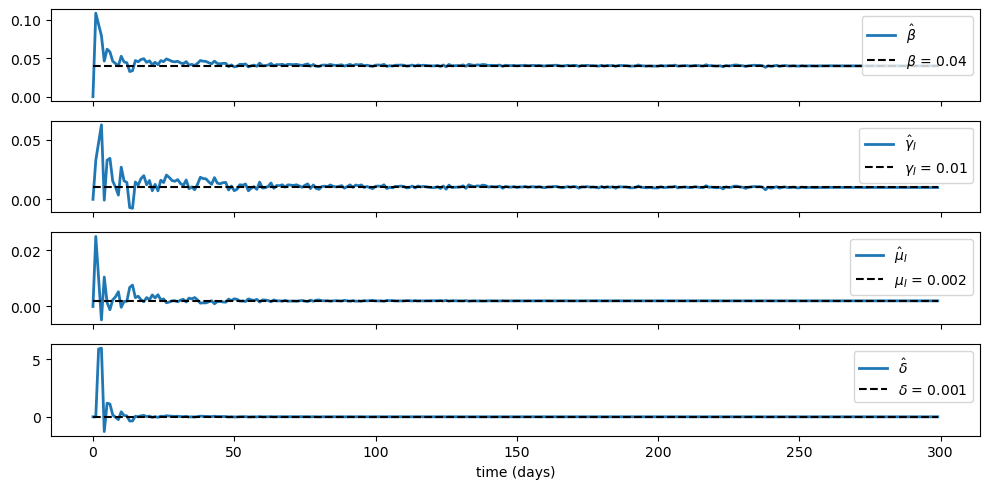

In [80]:
# plot the results
fig, ax = plt.subplots(4, figsize=(10,5), sharex=True)

# plot parameters

c = 0
for i, param in enumerate(["beta", "gamma_I", "gamma_Q", "mu_I", "mu_Q", "delta"]):
    if param in ["beta", "gamma_I", "mu_I", "delta"]:
        ax[c].plot(theta_estimated_exact[:300,i], label = "$\\hat\\{}$".format(param), linewidth=2)
        ax[c].plot(theta[i] * np.ones((300,)), "--", color="k", label = "$\\{}$ = {}".format(param, theta[i]))
        ax[c].legend(loc="upper right")
        c+=1

plt.savefig("observer_figures/param_est_exact.svg", bbox_inches='tight', format="svg")
plt.xlabel("time (days)")
fig.tight_layout()
plt.show()

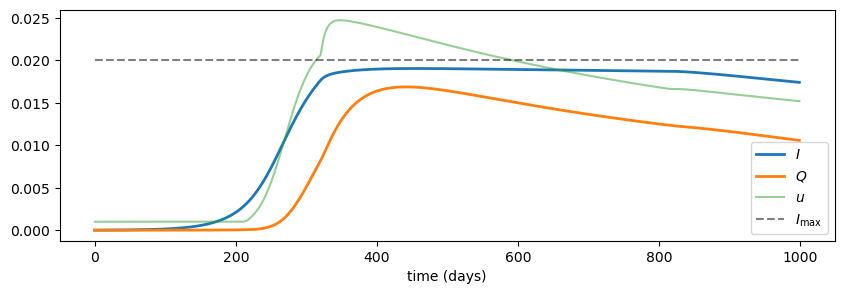

In [81]:
plt.figure(figsize=(10,3))

plt.plot(states_exact[:,1], label = "$I$", linewidth=2)
plt.plot(states_exact[:,3], label = "$Q$", linewidth=2)
plt.plot(states_exact[:,-1], label="$u$", alpha=0.5)
plt.plot(i_max * np.ones((len(states_exact),)), "--", color="k", label = "$I_{\max}$", alpha=0.5)
plt.legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("observer_figures/epidemic_mitigation_exact.svg", bbox_inches='tight', format="svg")
plt.show()

#### Results: LSTM-Based Observations

In [ ]:
solutions_observer_lstm = learning_based_mpc_observer(theta, sample_lenght, mpc_lenght,
                                                      i_max, c_Q, c_I, observation="lstm")
states_lstm, states_obs_lstm, theta_estimated_lstm = solutions_observer_lstm

In [23]:
filename = "observer_files/solutions_observer_lstm.pkl"

# # save results to file
# pkl.dump(solutions_observer_lstm, open(filename, "wb"))

# loads results and unpacks
solutions_observer_lstm = pkl.load(open(filename, "rb"))
states_lstm, states_obs_lstm, theta_estimated_lstm = solutions_observer_lstm

In [24]:
# print
print("theta_exact:",theta)
print("theta_estim:",theta_estimated_lstm[-1,:])

theta_exact: [0.04  0.01  0.025 0.002 0.001 0.001]
theta_estim: [0.02606554 0.00741985 0.025      0.00227994 0.001      0.00070715]


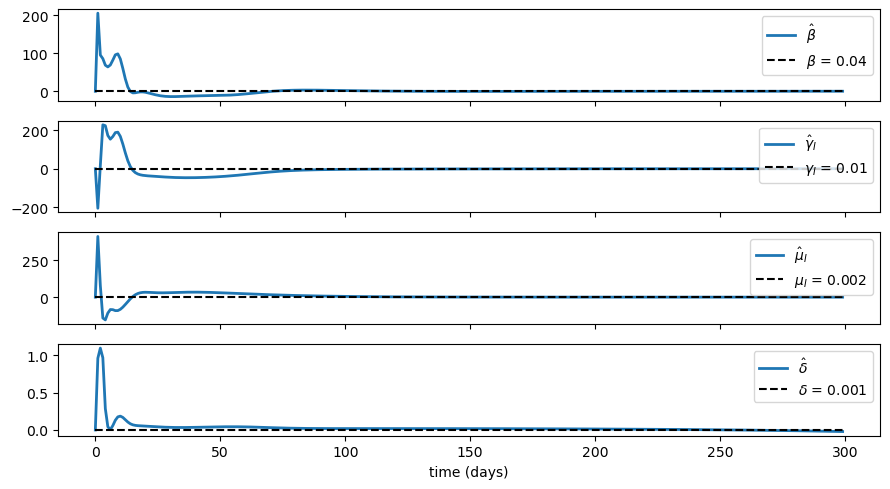

In [76]:
# plot the results
fig, ax = plt.subplots(4, figsize=(9,5), sharex=True)

# plot parameters

c = 0
for i, param in enumerate(["beta", "gamma_I", "gamma_Q", "mu_I", "mu_Q", "delta"]):
    if param in ["beta", "gamma_I", "mu_I", "delta"]:
        ax[c].plot(theta_estimated_lstm[:300,i], label = "$\\hat\\{}$".format(param), linewidth=2)
        ax[c].plot(theta[i] * np.ones((300,)), "--", color="k", label = "$\\{}$ = {}".format(param, theta[i]))
        ax[c].legend(loc="upper right")
        c+=1

# plt.savefig("observer_figures/param_est_lstm.svg", bbox_inches='tight', format="svg")
plt.xlabel("time (days)")
fig.tight_layout()
plt.show()

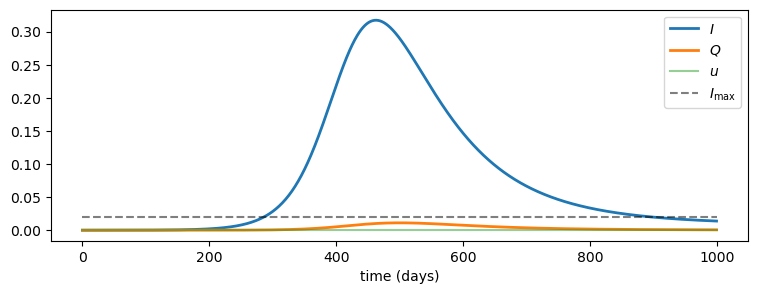

In [75]:
plt.figure(figsize=(9,3))

plt.plot(states_lstm[:,1], label = "$I$".format(param), linewidth=2)
plt.plot(states_lstm[:,3], label = "$Q$".format(param), linewidth=2)
plt.plot(states_lstm[:,-1], label="$u$", alpha=0.5)
plt.plot(i_max * np.ones((len(states_lstm),)), "--", color="k", label = "$I_{\max}$", alpha=0.5)
plt.legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("observer_figures/epidemic_mitigation_lstm.svg", bbox_inches='tight', format="svg")
plt.show()

## MPC from Control-Free State Evolution Predictor

### LSTM-Based Control-Free State Predictor

In [27]:
def train_generator(n_samples, input_lenght, output_lenght, u_max, u_min, theta_max):
  while True:
    # formats data
    x_train = np.zeros((n_samples, input_lenght, 2))
    y_train = np.zeros((n_samples, output_lenght, 2))

    for sample in range(n_samples):
      # samples random parameters
      theta = np.random.uniform(high=theta_max)

      # random initial state
      model = SIRQ(theta)
      state = np.random.rand(5)
      model.state = state/sum(state)
      
      # evolves inputs and outputs
      inputs = simulate(input_lenght, theta, u_max, u_min, model=model)
      outputs = simulate(output_lenght, theta, 0, 0, model=model)
      
      # updates train data
      x_train[sample, :, :] = inputs[:, [1,-1]]
      y_train[sample, :, :] = outputs[:, [1,-1]]

    yield x_train, y_train

In [28]:
@keras.saving.register_keras_serializable()
class FeedBack(keras.Model):
    def __init__(self, units, out_steps, out_features, **kwargs):
        super().__init__(**kwargs)

        # parameters
        self.units = units
        self.out_steps = out_steps
        self.out_features = out_features
        
        # layers
        self.cell = keras.layers.LSTMCell(units)
        self.dense = keras.layers.Dense(out_features)
        self.rnn = keras.layers.RNN(self.cell, return_state=True)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state


    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

    def get_config(self):
        base_config = super().get_config()

        config = {
            "units": self.units,
            "out_steps": self.out_steps,
            "out_features": self.out_features,
            "cell": keras.saving.serialize_keras_object(self.cell),
            "dense": keras.saving.serialize_keras_object(self.dense),
            "rnn": keras.saving.serialize_keras_object(self.rnn),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # deserialize layers
        cell = keras.saving.deserialize_keras_object(config.pop("cell"))
        dense = keras.saving.deserialize_keras_object(config.pop("dense"))
        rnn = keras.saving.deserialize_keras_object(config.pop("rnn"))
        
        # generate model
        model = cls(config.pop("units"), config.pop("out_steps"), config.pop("out_features"), **config)
        model.cell = cell
        model.dense = dense
        model.rnn = rnn
        
        return model


In [29]:
lstm_state_predictor = FeedBack(units=4, out_steps=10, out_features=2)

lstm_state_predictor.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

# print(lstm_state_predictor.summary())

In [ ]:
generator = train_generator(sample_lenght, input_lenght, mpc_lenght, u_max=u_max, u_min=u_min, theta_max=theta)
lstm_state_predictor.fit(generator, steps_per_epoch=1000, epochs=10, verbose=1)

In [30]:
filename = 'predictor_files/lstm_state_predictor.keras'

# save/load the model
# lstm_state_predictor.save(filename)
lstm_state_predictor = keras.models.load_model(filename)

#### Check Fitting

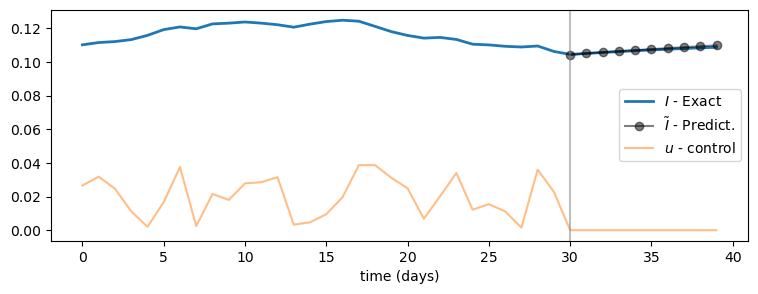

In [74]:
generator = train_generator(1, input_lenght, mpc_lenght, u_max=u_max, u_min=u_min, theta_max=theta_max)
sample_input, sample_output = next(generator)

plt.figure(figsize=(9,3))

plt.plot(range(input_lenght + mpc_lenght),
         np.concatenate([sample_input[0, :, 0],
                         sample_output[0, :, 0]]), label="$I$ - Exact", linewidth=2)

prediction = np.zeros((mpc_lenght, 2))
prediction[:,0] = np.arange(input_lenght, input_lenght + mpc_lenght)
prediction[:,1] = lstm_state_predictor(sample_input)[0,:,0]
plt.plot(prediction[:,0], prediction[:,1], "-o", color="k", label="$\\tilde{I}$ - Predict.", alpha=0.5)

plt.plot(range(input_lenght + mpc_lenght),
         np.concatenate([sample_input[0, :, 1],
                         sample_output[0, :, 1]]), label = "$u$ - control", alpha=0.5)

plt.axvline(input_lenght, color="gray", alpha=0.5)

plt.xlabel("time (days)")
plt.legend()
plt.savefig("predictor_figures/infected_prediction.svg", bbox_inches='tight', format="svg")
plt.show()

In [64]:
predictions = []

for i in range(input_lenght, len(sample)):
    prediction = np.zeros((mpc_lenght, 2))
    prediction[:,0] = np.arange(i, i+mpc_lenght)
    i_past = sample[i-input_lenght:i,[1,-1]]
    i_pred = lstm_state_predictor(np.array([i_past]))[0,:,0]
    prediction[:,1] = i_pred
    
    predictions.append(prediction)

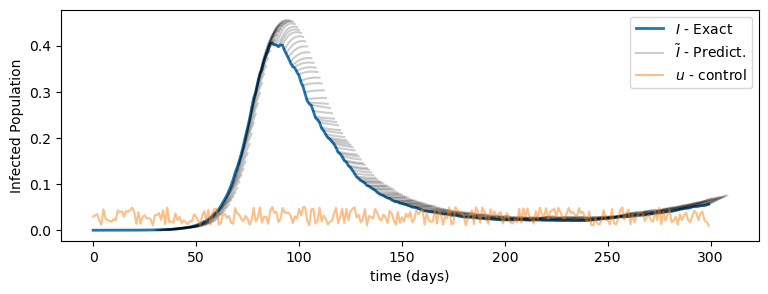

In [73]:
plt.figure(figsize=(9,3))

plt.plot(sample[:, 1], label="$I$ - Exact", linewidth=2)

for prediction in predictions:
    line, = plt.plot(prediction[:,0], prediction[:,1], color="k", alpha=0.2)
line.set_label("$\\tilde{I}$ - Predict.")

plt.plot(sample[:,-1], label = "$u$ - control", alpha=0.5)

plt.ylabel("Infected Population")
plt.xlabel("time (days)")

plt.legend()
plt.savefig("predictor_figures/infected_prediction_many.svg", bbox_inches='tight', format="svg")
plt.show()

### Control Law and MPC

In [66]:
def mpc_minimal_control(strategy, i_pred):
    w = MX.sym("w", 1)

    i_hat = []
    for k in range(1, len(i_pred)):
        if strategy == "one-step":
            i_hat_k = i_pred[k] - w*i_pred[k-1]
        if strategy == "translation":
            i_hat_k = i_pred[k] - w*np.sum(i_pred[:k])
        if strategy == "propagation":
            i_hat_k = i_pred[0] * (1-w)**k
            for n in range(k):
                i_hat_k += (i_pred[n+1]-i_pred[n])*(1 - w)**(k-n-1)
        if strategy == "proportional":
            i_hat_k = i_pred[0]
            for n in range(k):
                i_hat_k *= (i_pred[n+1]/i_pred[n] - w)
        i_hat.append(i_hat_k)
    # print(i_hat)    
    i_hat = hcat(i_hat)

    # Allocate an NLP solver
    nlp = {'f':w, 'x':w, 'g':i_hat}
    opts = {"ipopt.print_level":0, "print_time":0}
    solver = nlpsol("solver", "ipopt", nlp, opts,)

    # Bounds on u and initial condition
    arg = dict()
    arg["lbx"] = u_min
    arg["ubx"] = u_max
    arg["ubg"] = i_max

    # Solve the problem
    res = solver(**arg)

    # Get the optimal solution
    return float(res["x"])

In [67]:
def mpc_optimal_control_gekko(strategy, i_pred, x0, u_min, u_max):
    # start model
    gekko_model = GEKKO()
    gekko_model.time = np.linspace(0, mpc_lenght-1, len(i_pred))

    # I = gekko_model.Var(x0[0])
    I_ = gekko_model.Param(i_pred) # \tilde{I}
    Q = gekko_model.Var(x0[1])
    u = gekko_model.Var(lb=u_min, ub=u_max)
    gekko_model.free(u)

    if strategy == "translation":
        # gekko_model.Equation(I.dt() == I_.dt() - u * I_)
        aux = gekko_model.integral(u*I_)
        I = gekko_model.Intermediate(I_ - aux)
    
    if strategy == "propagation":
        # gekko_model.Equation(I.dt() == I_.dt() - u * I)
        aux1 = gekko_model.integral(u)
        aux2 = gekko_model.Intermediate( np.e**(-aux1) )
        aux3 = gekko_model.integral(u * aux2**(-1) * I_ )
        I = gekko_model.Intermediate(I_ + x0[0]*(1-aux2) - aux2 * aux3 )

    if strategy == "proportional":
        # gekko_model.Equation(I.dt() == I_.dt() * I/I_ - u*I)
        aux1 = gekko_model.integral(u)
        aux2 = gekko_model.Intermediate( np.e**(-aux1) )
        I = gekko_model.Intermediate(I_*aux2)
                
    gekko_model.Equation(Q.dt() == u*I - gamma_q*Q - mu_q*Q)

    # mitogation
    gekko_model.Equation(I <= i_max)

    # costs
    gekko_model.Minimize((u*(1-Q))**2 + c_Q*Q**2 + c_I*I**2)

    # solve
    try:
        gekko_model.options.MAX_ITER = 1000
        gekko_model.options.IMODE = 6
        gekko_model.solve(disp=False)

        w = u.VALUE[1]
    except:
        print("Warning:", "error solving problem. Returning maximun control.")
        w = u_max
    
    return w

In [68]:
def mpc_optimal_control_casadi(strategy, I_pred, X0, u_min, u_max):
    # Control for all segments
    U = MX.sym("U", mpc_lenght)

    # strategies
    if strategy == "translation":
        F = lambda I, i, I_pred: (I_pred[i] - I_pred[i-1]) 
    
    if strategy == "propagation":
        F = lambda I, i, I_pred: (I_pred[i] - I_pred[i-1])

    if strategy == "proportional":
        F = lambda I, i, I_pred: (I_pred[i] - I_pred[i-1])*I/I_pred[i-1]

    # Integrate over all intervals
    X=[X0]
    for i in range(1, mpc_lenght):
        X_ = X[-1] + sirq_dynamics_(X[-1],U[i-1], F, i, I_pred)
        X.append(X_)
    X = hcat(X)

    I = X[0,:].T
    Q = X[1,:].T

    # Objective function and constraints
    J = sum1(U**2*(1-Q)**2 + c_Q*Q**2 + c_I*I**2)
    G = vertcat(I, U*(1-Q))

    # Allocate an NLP solver
    nlp = {'f':J, 'x':U, 'g':G}
    opts = {"ipopt.print_level":0, "print_time":0}
    solver = nlpsol("solver", "ipopt", nlp, opts,)

    # Bounds on u and initial condition
    arg = dict()
    arg["lbg"] = [-inf]*mpc_lenght + [u_min]*mpc_lenght
    arg["ubg"] = [i_max]*mpc_lenght + [u_max]*mpc_lenght

    # Solve the problem
    res = solver(**arg)

    # Get the optimal solution
    return np.array(res["x"]), float(res["f"])


def sirq_dynamics_(x, u, F, i, I_pred):
    # unpack states 
    I = x[0] # infected
    Q = x[1] # quarantine

    # ODE right hand side
    idot = F(I, i, I_pred) - u*I
    qdot = u*I - gamma_q*Q - mu_q*Q

    return vertcat(idot, qdot)

In [69]:
def pmp_functions_(strategy, I_pred, u_min, u_max):
    # # defining model dependent systems
    if strategy == "translation":
        # model functions
        F = lambda i, x_i: I_pred[i] - I_pred[i-1]
        F_I = lambda i, x_i: 0
        G = lambda i, x_i: I_pred[i]
        G_I = lambda i, x_i: 0
    
    if strategy == "propagation":
        F = lambda i, x_i: (I_pred[i] - I_pred[i-1])
        F_I = lambda i, x_i: 0
        G = lambda i, x_i: x_i[0]
        G_I = lambda i, x_i: 1

    if strategy == "proportional":
        F = lambda i, x_i: (I_pred[i] - I_pred[i-1])*x_i[0]/I_pred[i-1]
        F_I = lambda i, x_i: (I_pred[i] - I_pred[i-1])/I_pred[i-1]
        G = lambda i, x_i: x_i[0]
        G_I = lambda i, x_i: 1

    # system for Q, L, I
    f_x_I = lambda i, x_i, u_i: F(i, x_i) - u_i*G(i, x_i)
    f_x_Q = lambda i, x_i, u_i: u_i * x_i[0] - gamma_q*x_i[1] - mu_q*x_i[1]
    f_x_L = lambda i, x_i, u_i: (u_i*(1 - x_i[1]))**2 + c_Q*x_i[1]**2 + c_I*x_i[0]**2
        
    # system for p1,p2,p3
    f_p_1 = lambda i, p_i, x_i, u_i: -p_i[0]*(F_I(i, x_i)-u_i*G_I(i, x_i)) - p_i[1]*u_i - p_i[2]*2*c_I*x_i[0]
    f_p_2 = lambda i, p_i, x_i, u_i: -p_i[0]*0 + p_i[1]*(gamma_q + mu_q) + p_i[2]*(u_i**2*(1-x_i[1])+2*c_Q*x_i[1])
    f_p_3 = lambda i, p_i, x_i, u_i: -p_i[0]*0 - p_i[1]*0 - p_i[2]*0
    
    # defining complete systems for x, p
    f_x = lambda i, x_i, u_i: np.array([f_x_I(i, x_i, u_i), f_x_Q(i, x_i, u_i), f_x_L(i, x_i, u_i)])
    f_p = lambda i, p_i, x_i, u_i: np.array([f_p_1(i, p_i, x_i, u_i), f_p_2(i, p_i, x_i, u_i), f_p_3(i, p_i, x_i, u_i)])
    f_u = lambda i, p_i, x_i: np.clip((p_i[0]*x_i[0]-p_i[1]*x_i[0])/(p_i[2]*2*(1-x_i[1])**2), a_min=u_min, a_max=u_max)
    
    return f_x, f_p, f_u

In [70]:
def sweep_method_step(x, p, u, x_0, p_t, f_x, f_p, f_u):
    # updates x(t) forwards in time
    x[:,0] = x_0
    for i in range(1, mpc_lenght):
        x[:,i] = x[:,i-1] + f_x(i-1, x[:,i-1], u[i-1])
    
    # updates p(t) backwards in time
    p[:,-1] = p_t
    for i in range(mpc_lenght-1, 0, -1):
        p[:,i-1] = p[:,i] - f_p(i,p[:,i], x[:,i], u[i-1]) # attention to the signals

    # updates u(t) at each time
    for i in range(mpc_lenght-1):
        u[i] = f_u(i, p[:,i], x[:,i])

    return x, p, u

def shooting_method_step(x, p, u, x_0, p_0, f_x, f_p, f_u):
    # updates x(t) and p(t) forwards in time
    x[:,0] = x_0
    p[:,0] = p_0
    for i in range(1,mpc_lenght):
        u[i-1] = f_u(i-1, p[:,i-1], x[:,i-1])
        x[:,i] = x[:,i-1] + f_x(i-1, x[:,i-1], u[i-1])
        p[:,i] = p[:,i-1] + f_p(i-1, p[:,i-1], x[:,i-1], u[i-1]) # attention to the signals

    return x, p, u

def shooting_method_step_p_0(x, p, u, x_0, p_0, p_t, f_x, f_p, f_u):
    root_scalar_f = lambda p_0: shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_0.copy(), f_x, f_p, f_u)[1][:,-1] - p_t
    res = root(root_scalar_f, x0=p_0)
    return res["x"]

def mpc_optimal_control_numerical(method, strategy, i_pred, x_0, u_min, u_max, N=1000, tol=1e-10):
    p_t = np.array([0,0,1])
    p_0 = np.array([1,1,1])
    # p_0 = np.random.rand(3)
    x_0 = np.array([*x_0, 0])

    u = np.zeros(mpc_lenght)
    x = np.zeros((3, mpc_lenght))#; x[:,0] = x_0
    p = np.ones((3, mpc_lenght))#; p[:,-1] = p_t
    
    # defines mappings
    f_x, f_p, f_u = pmp_functions_(strategy, i_pred, u_min, u_max)

    for i in range(N):
        x_old, p_old, u_old = x.copy(), p.copy(), u.copy()

        if method == "sweep":
            x, p, u = sweep_method_step(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_t.copy(), f_x, f_p, f_u)
        
        if method == "shooting":
            p_0 = shooting_method_step_p_0(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_0.copy(), p_t.copy(), f_x, f_p, f_u) 
            x, p, u = shooting_method_step(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_0.copy(), f_x, f_p, f_u)
        
        states = np.concatenate([arr.ravel() for arr in (x, p, u)])
        states_old = np.concatenate([arr.ravel() for arr in (x_old, p_old, u_old)])
        stopping_criterion_error = np.linalg.norm(states - states_old)/np.linalg.norm(states) 
        
        # check for stopping condition
        if stopping_criterion_error < tol:
            break
    else:
        print("warning: maximun iteration reached. criterion:", stopping_criterion_error)

    return u, x[-1,-1]

In [71]:
def predict(prediction, epsilon_i, i, state=None, states=None, w=0):
    if prediction == "lstm":
        x_input = states[i-input_lenght:i, [1, -1]]
        i_pred = lstm_state_predictor(x_input.reshape(1,-1,2))[0,:,0]

    if prediction == "exact":
        model = SIRQ(theta)
        model.state = state
        i_pred = np.zeros(mpc_lenght)
        for i in range(mpc_lenght):
            i_pred[i] = model.update(w)[1]

    return np.clip(i_pred, a_min=epsilon_i, a_max=1)

def control_cost_real(theta, state, w):
    model = SIRQ(theta)
    model.state = state.copy()
    
    states = np.zeros((mpc_lenght, len(model.state) + 1))

    # updates system
    for i, w_ in enumerate(w):
        state = model.update(w_)
        states[i,:-1] = state
        states[i, -1] = w_
    
    # computes costs
    cost = states[:,-1]*(1-states[:,3]) + c_Q*states[:,3]**2 + c_I*states[:,1]**2
    return np.sum(cost)


def learning_based_mpc(theta, simulation_lenght, start_lenght, epsilon_i=1e-10,
                                strategy=None, prediction=None, problem=None):
    
    # initiates model simulator
    model = SIRQ(theta)

    # initiates states
    states = np.zeros((simulation_lenght, len(model.state) + 1))
    report = {"mpc_controls": [], "mpc_costs": [], "real_costs":[]}


    # simulates under control
    for i in tqdm(range(0, simulation_lenght)):
        # prediction stategies
        if strategy is None or prediction is None or problem is None or i < start_lenght:
            w = u_min
        else:
            # prediction
            i_pred = predict(prediction, epsilon_i, i, model.state, states)
            x0 = (i_pred[0], model.state[3])

            # minimal control
            if problem == "minimal":
                w = mpc_minimal_control(strategy, i_pred)
                l = w*mpc_lenght
                w = w*np.ones(mpc_lenght)
            
            # using solvers
            if problem == "gekko":
                w,l = mpc_optimal_control_gekko(strategy, i_pred, x0, u_min, u_max)
            if problem == "casadi":
                w,l = mpc_optimal_control_casadi(strategy, i_pred, x0, u_min, u_max)
            
            # numerical method
            if problem == "sweep":
                w,l = mpc_optimal_control_numerical(problem, strategy, i_pred, x0, u_min, u_max)
            if problem == "shooting":
                w,l = mpc_optimal_control_numerical(problem, strategy, i_pred, x0, u_min, u_max)
            
            # compute real cost by strategy
            r = control_cost_real(theta, model.state, w)
            
            # updates mpc reports
            report["mpc_costs"].append(l)
            report["real_costs"].append(r)
            report["mpc_controls"].append(w)

            # gets only first control
            w = w[0]
             
        # updates system
        state = model.update(w)
        states[i, :-1] = state
        states[i, -1] = w

    # returns
    return states, report


In [72]:
# define new parameters
strategies = ["translation", "propagation", "proportional"]
equations = [
    "$\\frac{d}{dt}\hat{x}(t) = f(t,\\tilde{x}(t)) + g(t,\\tilde{x}(t), u(t))$",
    "$\\frac{d}{dt}\hat{x}(t) = f(t,\\tilde{x}(t)) + g(t,\hat{x}(t), u(t))$",
    "$\\frac{d}{dt}\hat{x}(t) = f(t,\\tilde{x}(t))\\frac{\hat{x}(t)}{\\tilde{x}(t)} + g(t,\hat{x}(t), u(t))$"]

### Minimal Testing for Control

In [29]:
solutions_pred_minimal_exact = []

for i, strategy in enumerate(strategies):
    solution = learning_based_mpc(theta, sample_lenght, start_lenght=input_lenght,
                                  strategy=strategy, prediction="exact", problem="minimal")
    solutions_pred_minimal_exact.append(solution)

100%|██████████| 1000/1000 [00:25<00:00, 38.90it/s]


In [41]:
filename = "predictor_files/solutions_pred_minimal_exact.pkl"

# pkl.dump(solutions_pred_minimal_exact, open(filename, "wb"))
solutions_pred_minimal_exact = pkl.load(open(filename, "rb"))

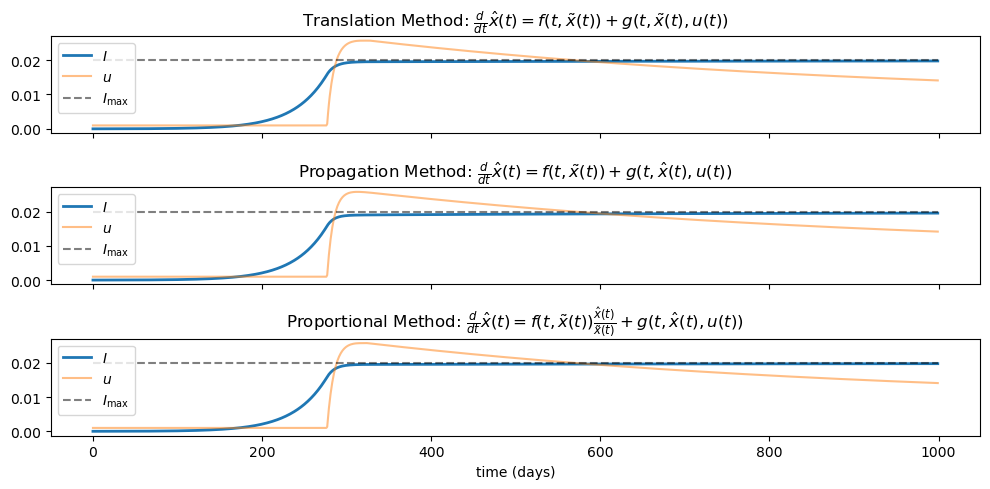

In [114]:
fig, ax = plt.subplots(len(strategies), figsize=(10,5), sharex=True)

for i, (strategy, equation, (states, _))  in enumerate(zip(strategies, equations, solutions_pred_minimal_exact)):
    ax[i].plot(states[:,1], label="$I$", linewidth=2)
    ax[i].plot(states[:,-1], label="$u$", alpha=0.5)
    ax[i].plot(i_max*np.ones(len(states)), "--", label="$I_{\max}$", color="k", alpha=0.5)

    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_minimal_exact.svg", bbox_inches='tight', format="svg")
plt.show()

In [261]:
solutions_pred_minimal_lstm = []

for i, strategy in enumerate(strategies):
    solution = learning_based_mpc(theta, sample_lenght, start_lenght=input_lenght,
                                  strategy=strategy, prediction="lstm", problem="minimal",)
    solutions_pred_minimal_lstm.append(solution)

100%|██████████| 1000/1000 [04:35<00:00,  3.64it/s]


In [46]:
filename = "predictor_files/solutions_pred_minimal_lstm.pkl"

# pkl.dump(solutions_pred_minimal_lstm, open(filename, "wb"))
solutions_pred_minimal_lstm = pkl.load(open(filename, "rb"))

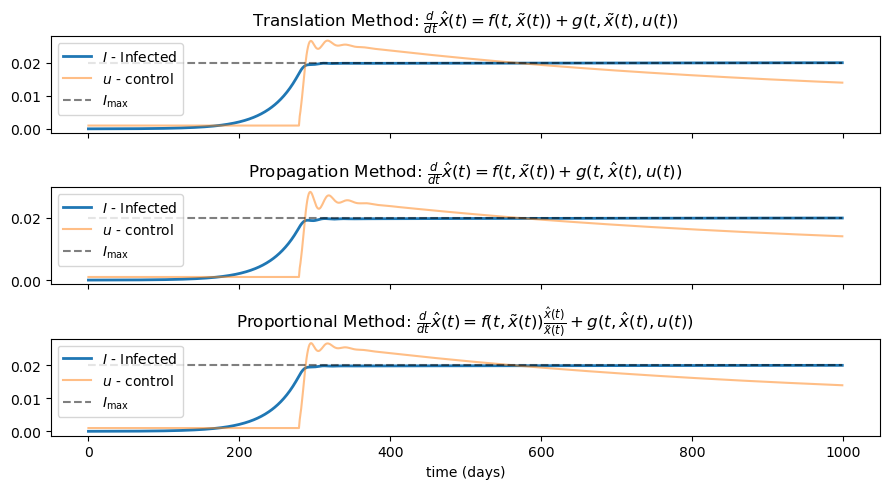

In [115]:
fig, ax = plt.subplots(len(strategies), figsize=(9,5), sharex=True)
# fig, ax = plt.subplots(len(strategies))

for i, (strategy, equation, (states, _))  in enumerate(zip(strategies, equations, solutions_pred_minimal_lstm)):
    ax[i].plot(states[:,1], label="$I$ - Infected", linewidth=2)
    ax[i].plot(states[:,-1], label="$u$ - control", alpha=0.5)
    ax[i].plot(i_max*np.ones(len(states)), "--", label="$I_{\max}$", color="k", alpha=0.5)
    
    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_minimal_lstm.svg", bbox_inches='tight', format="svg")
plt.show()

### Optimal Control Problem

In [266]:
solutions_pred_optimal_exact = []

for i, strategy in enumerate(strategies):
    solution = learning_based_mpc(theta, sample_lenght, start_lenght=input_lenght,
                                  strategy=strategy, prediction="exact", problem="shooting")
    solutions_pred_optimal_exact.append(solution)

100%|██████████| 1000/1000 [00:02<00:00, 491.70it/s]


In [ ]:
filename = "predictor_files/solutions_pred_optimal_exact.pkl"

# pkl.dump(solutions_pred_optimal_exact, open(filename, "wb"))
solutions_pred_optimal_exact = pkl.load(open(filename, "rb"))

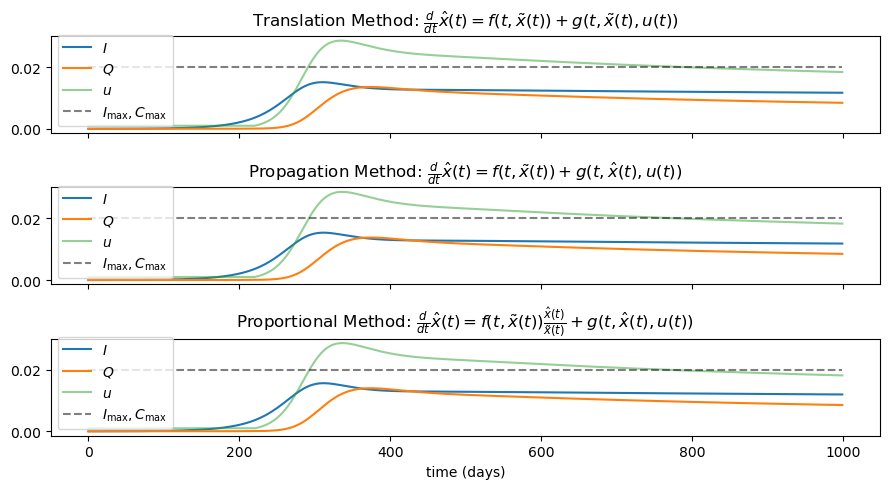

In [118]:
fig, ax = plt.subplots(3, figsize=(9,5), sharex=True)
# fig, ax = plt.subplots(len(strategies))

for i, (strategy, equation, (states, _))  in enumerate(zip(strategies, equations, solutions_pred_optimal_exact)):
    ax[i].plot(states[:,1], label="$I$", linewidth=1.5)
    ax[i].plot(states[:,3], label="$Q$", linewidth=1.5)
    ax[i].plot(states[:,-1], label="$u$", alpha=0.5)
    ax[i].plot(i_max*np.ones(len(states)), "--", label="$I_{\max}, C_{\max}$", color="k", alpha=0.5)

    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_optimal_exact.svg", bbox_inches='tight', format="svg")
plt.show()

In [271]:
solutions_pred_optimal_lstm = []

for i, strategy in enumerate(strategies):
    solution = learning_based_mpc(theta, sample_lenght, start_lenght=input_lenght,
                                  strategy=strategy, prediction="lstm", problem="shooting")
    solutions_pred_optimal_lstm.append(solution)

100%|██████████| 1000/1000 [00:38<00:00, 26.07it/s]


In [ ]:
filename = "predictor_files/solutions_pred_optimal_lstm.pkl"

# pkl.dump(solutions_pred_optimal_lstm, open(filename, "wb"))
solutions_pred_optimal_lstm = pkl.load(open(filename, "rb"))

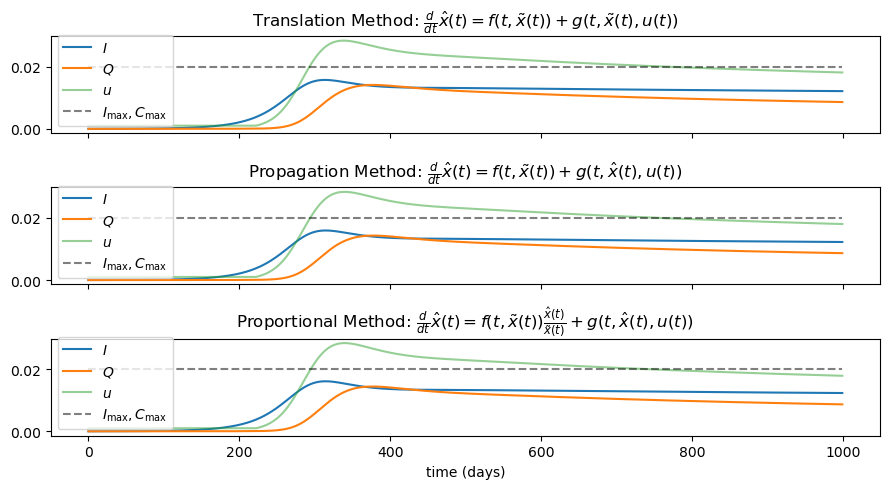

In [272]:
fig, ax = plt.subplots(3, figsize=(9,5), sharex=True)
# fig, ax = plt.subplots(len(strategies))

for i, (strategy, equation, (states, _))  in enumerate(zip(strategies, equations, solutions_pred_optimal_lstm)):
    ax[i].plot(states[:,1], label="$I$", linewidth=1.5)
    ax[i].plot(states[:,3], label="$Q$", linewidth=1.5)
    ax[i].plot(states[:,-1], label="$u$", alpha=0.5)
    ax[i].plot(i_max*np.ones(len(states)), "--", label="$I_{\max}, C_{\max}$", color="k", alpha=0.5)

    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_optimal_lstm.svg", bbox_inches='tight', format="svg")
plt.show()

### Varying Cost Weights

In [200]:
strategy = strategies[0]
solutions_varying_weights = dict()

cQ_values = [1,10,100]
cI_values = [1,10,100]

for c_Q in cQ_values:
    for c_I in cI_values:
        states, _ = learning_based_mpc(theta, sample_lenght, start_lenght=input_lenght,
                                       strategy=strategy, prediction="exact", problem="casadi")
        solutions_varying_weights["{}-{}".format(c_Q,c_I)] = states

100%|██████████| 1000/1000 [00:16<00:00, 62.10it/s]


In [ ]:
filename = "predictor_files/solutions_varying_weights.pkl"

# pkl.dump(solutions_varying_weights, open(filename, "wb"))
solutions_varying_weights = pkl.load(open(filename, "rb"))

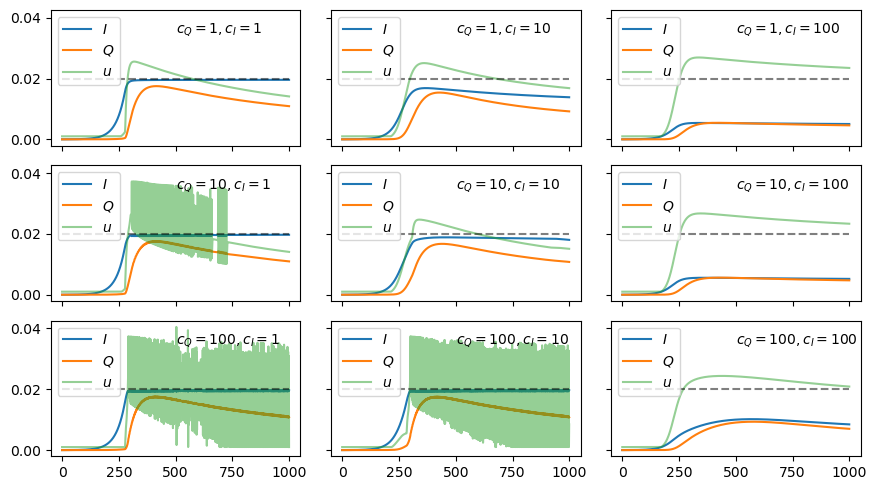

In [275]:
fig, ax = plt.subplots(3,3, figsize=(9,5), sharex=True, sharey=True)

for i, c_Q in enumerate(cQ_values):
    for j, c_I in enumerate(cI_values):
        states = solutions_varying_weights["{}-{}".format(c_Q,c_I)]
        ax[i,j].plot(states[:,1], label="$I$", linewidth=1.5)
        ax[i,j].plot(states[:,3], label="$Q$", linewidth=1.5)
        ax[i,j].plot(states[:,-1], label="$u$", alpha=0.5)
        ax[i,j].plot(i_max*np.ones(len(states)), "--", color="k", alpha=0.5)

        ax[i,j].text(x=500, y=0.035, s="$c_Q={}, c_I={}$".format(c_Q,c_I))

        ax[i,j].legend()

# plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_varying_cost_weights.svg", bbox_inches='tight', format="svg")
plt.show()